<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/main/2.2_response_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 2.2 Aggregation and Response Synthesis (Post-Retrieval) -<br> Merging retrieved results and applying advanced post-retrieval techniques

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** This step deals with post-retrieval processing. After an initial set of candidate chunks is retrieved, techniques are applied to refine these results before they are passed to the LLM. The primary focus is on re-ranking, using sophisticated models to reorder the retrieved chunks based on relevance. Other techniques like generating summaries or fusing information from multiple chunks are also explored.

# 1.0 Loading Data and functions from previous stage

## 1.1 Setup of the environment

### Installations and loading of packages

In [ ]:
!pip install torch torchvision torchaudio

In [1]:
import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    # The model will automatically be placed on the GPU
else:
    print("GPU is not available. Running on CPU.")

GPU is available: NVIDIA GeForce RTX 5070


In [ ]:
!pip install langchain langchain_groq faiss_cpu

Below the necessary libraries are installed and loaded into the environment.

In [2]:
import os
import re
import json
import asyncio
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pickle
import faiss
from typing import Optional, List
from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForCausalLM, AutoTokenizer

In [3]:
# Allows asyncio to run in a notebook environment
import nest_asyncio
nest_asyncio.apply()

from typing import List, Literal
from pydantic import BaseModel, Field
from openai import OpenAI

### Setting seeds and mounting Google Drive storage folder

In [4]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

### Check properties of environment

In [9]:
!nvidia-smi

Sat Jun  7 09:07:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.5.26.0.

## 1.2 Loading the datasets

In [8]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [7]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [42]:
# Run this cell if working locally
df = pd.read_csv('data/Stage2-02-chunked-dataset.csv')
with open('data/Stage2-08-q-a-file-with-relevancy.pkl', 'rb') as f:
	Q_A_ground_thruth_relevancy_dict = pickle.load(f)

	filename = 'data/Stage3-01-precalc-retrieved-chunks.pkl'
	with open(filename, 'rb') as f:
		precalc_retrieved_chunks = pickle.load(f)
	print(f"Dictionary loaded from {filename}:")

# load files in local computer and api from data .env
from dotenv import dotenv_values

env_vars = dotenv_values('data/.env')
OPENAI_API_KEY = env_vars.get('OPENAI_API_KEY', None)
print(f"Loaded OPENAI_API_KEY: {'***' if OPENAI_API_KEY else 'Not found'}")

Dictionary loaded from data/Stage3-01-precalc-retrieved-chunks.pkl:
Loaded OPENAI_API_KEY: ***


## 1.3 Build Dense Vector Store and define Retrievers

In [10]:
# Build FAISS Index for Multilingual Dense Retrieval
# Uses Sentence-BERT (distiluse-base-multilingual-cased-v1) for multilingual embeddings (English & German supported)
def build_faiss_index(df, model_name='sentence-transformers/distiluse-base-multilingual-cased-v1'):
    model = SentenceTransformer(model_name)
    # Convert all chunk texts to embeddings (normalized for cosine similarity)
    embeddings = model.encode(df['chunk_text'].tolist(), convert_to_numpy=True, normalize_embeddings=True)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # Inner product on normalized vectors = cosine similarity
    index.add(embeddings)
    return model, index, embeddings, df.reset_index(drop=True)

In [11]:
# Multilingual Semantic Retrieval (English or German query)
def retrieve_dense_faiss(query, model, index, df, top_k=5):
    # Query can be in English or German (model is multilingual)
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, indices = index.search(query_vec, top_k)
    results = df.iloc[indices[0]].copy()
    results['score'] = scores[0]
    return results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

# Build FAISS index only once (if not already built)
dense_model, faiss_index, dense_embeddings, dense_df = build_faiss_index(df)

In [12]:
test_query = "Who is the rector of ETH"
print("Query:", test_query)
dense_results = retrieve_dense_faiss(test_query, dense_model, faiss_index, dense_df)
display(dense_results)

Query: Who is the rector of ETH


,unique_chunk_id,chunk_text,score,title
15758,2547_00,ETH is one of the world’s leading technical un...,0.494082,Where next for eth
10407,1289_01,Was macht der Direktor des ETH-Zentrums Singap...,0.477289,Wer in singapur forschen will soll sich jetzt ...
15177,2345_02,What does this mean for members of ETH who app...,0.474332,Ombudspersons trio is complete
12798,1917_06,## Wie die ETH zu ihrer Rektorin oder ihrem Re...,0.468042,Guenther dissertori als rektor eth zuerich
19189,3205_02,How relevant is it whether ETH acts as the ove...,0.462756,Roland siegwart why the nccrs are so important...


In [ ]:
# Define OpenAI Api Key
import openai
from google.colab import userdata

api_key = userdata.get('openai_advAI')

In [19]:
# Pydantic Model for LLM Output
class GeneratedHydeDocuments(BaseModel):
    documents: List[str] = Field(
        description="A list of three diverse, concise, and relevant hypothetical documents that comprehensively answer the original query.",
        min_length=3,
        max_length=3
    )

In [20]:
# OpenAI Function for Generating Variations
# Note: You'll need to have the OpenAI API key set as an environment variable OPENAI_API_KEY
# or pass it to the OpenAI client.

def get_openai_client(api_key: str = None):
    """Initializes and returns an OpenAI client."""
    return OpenAI(api_key=api_key)

def generate_variations_openai(
    original_query: str,
    variation_type: Literal["queries", "hyde_documents"],
    num_variations: int = 3,
    llm_model: str = "gpt-4o",
    client: OpenAI = None,
    api_key: str = None
) -> List[str]:
    """
    Generates multiple query variations or hypothetical documents using OpenAI LLM.
    """
    if client is None:
        client = get_openai_client(api_key=api_key) # Use passed api_key

    if num_variations != 3:
        # This warning is good, Pydantic models enforce 3.
        print(f"Warning: Pydantic models are set for 3 variations. Generating {num_variations} might conflict if not 3.")
    json_structure_example_hyde = f"""
Your response MUST be a JSON object with a single key "documents".
The value of "documents" MUST be a list of exactly {num_variations} strings, where each string is a hypothetical document.
Example for {num_variations} variations:
{{
  "documents": [
    "hypothetical document text 1...",
    "hypothetical document text 2...",
    "hypothetical document text 3..."
  ]
}}
"""
    if variation_type == "hyde_documents":
        type_desc = "hypothetical documents. Each document should be a concise, ideal answer to the original query, rich in relevant keywords and concepts, and diverse from the others."
        json_structure_guidance = json_structure_example_hyde
    else:
        raise ValueError("variation_type must be 'queries' or 'hyde_documents'")

    system_prompt_template = """
You are an expert in search query optimization and information retrieval.
Your primary task is to generate exactly {num_variations} diverse and effective {type_description} based on the original user query.
These variations are crucial for retrieving the most relevant documents from a corpus.

{json_guidance}

Ensure your output strictly adheres to this JSON structure. Do not include any other text, explanations, or apologies.
"""
    system_prompt = system_prompt_template.format(
        num_variations=num_variations,
        type_description=type_desc,
        json_guidance=json_structure_guidance
    )
    user_prompt = f"Original Query: '{original_query}'"

    try:
        response = client.chat.completions.create(
            model=llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_object"},
            temperature=0.6,
        )

        json_response_str = response.choices[0].message.content

        parsed_output = GeneratedHydeDocuments.model_validate_json(json_response_str)
        return parsed_output.documents

    except Exception as e:
        print(f"Error calling OpenAI or parsing response: {e}")
        # Fallback to simple placeholder variations in case of API error
        # Using a more distinct fallback to differentiate from potential successful but simple LLM output
        error_prefix = "ERROR_FALLBACK_"
        return [f"{error_prefix}Hypothetical document for {original_query} - version {i+1}. This document details..." for i in range(num_variations)]

In [ ]:
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
print("Query:", test_query)
print("HyDE Documents:")
pprint.pprint(generate_variations_openai(test_query, variation_type="hyde_documents", api_key=api_key))

In [21]:
def min_max_normalize(scores_series):
    min_score = scores_series.min()
    max_score = scores_series.max()

    if max_score == min_score:
        return pd.Series([0.0 if min_score == 0 else 1.0] * len(scores_series),
                         index=scores_series.index, dtype=float)

    normalized_scores = (scores_series - min_score) / (max_score - min_score)
    return normalized_scores

def normalize_scores(df_results, score_column='score'):
    """
    Normalizes scores in a DataFrame column to a 0-1 range.
    Uses the min_max_normalize function.
    """
    df_results[score_column] = min_max_normalize(df_results[score_column])
    return df_results

In [22]:
def retrieve_dense_faiss_hyde_multi(query, model, dense_embeddings, dense_df, top_k=5):
    if dense_embeddings is None or dense_df.empty:
        return pd.DataFrame(columns=['unique_chunk_id', 'chunk_text', 'score', 'title'])

    hyde_documents = generate_variations_openai(query, variation_type="hyde_documents",
                                                api_key=api_key, num_variations=3)
    total_scores = np.zeros(len(dense_df))

    for hyde_doc_text in hyde_documents:
        hyde_vec = model.encode([hyde_doc_text], convert_to_numpy=True, normalize_embeddings=True)
        current_scores = (hyde_vec @ dense_embeddings.T).flatten()
        total_scores += current_scores

    num_docs = len(hyde_documents)
    avg_scores_values = total_scores / num_docs
    avg_scores = pd.Series(avg_scores_values, index=dense_df.index)

    normalized_scores = min_max_normalize(avg_scores)

    results_df = dense_df.copy()
    results_df['score'] = normalized_scores

    top_results = results_df.sort_values('score', ascending=False).head(top_k)
    return top_results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

In [25]:
def retrieve_hybrid_standard_dense_plus_dense_hyde(
    query: str,
    # Shared Dense components
    dense_model,         # SentenceTransformer model
    dense_df: pd.DataFrame, # DataFrame of documents for dense retrieval
    # Standard Dense specific
    faiss_index,         # FAISS index for standard dense search
    # Dense HyDE specific
    dense_embeddings,    # Numpy array of pre-computed document embeddings for HyDE part
    # Retrieval parameters
    top_k: int = 5,      # Final number of chunks to return
    weight_standard_dense: float = 0.3,
    weight_dense_hyde: float = 0.7
):
    """
    Retrieves and combines documents using Standard Dense and Dense HyDE retrieval.

    Args:
        query (str): The search query.
        dense_model: The SentenceTransformer model (used by both retrievers).
        dense_df: DataFrame of documents (used by both retrievers).
        faiss_index: FAISS index for standard dense retrieval.
        dense_embeddings: Numpy array of pre-computed document embeddings for Dense HyDE.
        top_k (int): The final number of documents to return.
        weight_standard_dense (float): Weight for the standard dense scores.
        weight_dense_hyde (float): Weight for the Dense HyDE scores.

    Returns:
        pd.DataFrame: DataFrame of the top_k retrieved documents with their combined scores.
    """
    intermediate_top_k = max(20, 4 * top_k)

    # 1. Retrieve with Standard Dense Search
    std_dense_results_raw = retrieve_dense_faiss(
        query, dense_model, faiss_index, dense_df, top_k=intermediate_top_k)

    std_dense_results_normalized = normalize_scores(std_dense_results_raw.copy(), score_column='score')
    std_dense_results_normalized['score'] *= weight_standard_dense
    std_dense_results_final = std_dense_results_normalized[['unique_chunk_id', 'chunk_text', 'title', 'score']].set_index('unique_chunk_id')

    # 2. Retrieve with Dense HyDE
    dense_hyde_results_raw = retrieve_dense_faiss_hyde_multi(
        query, dense_model, dense_embeddings, dense_df, top_k=intermediate_top_k)

    dense_hyde_results_normalized = normalize_scores(dense_hyde_results_raw.copy(), score_column='score')
    dense_hyde_results_normalized['score'] *= weight_dense_hyde
    dense_hyde_results_final = dense_hyde_results_normalized[['unique_chunk_id', 'chunk_text', 'title', 'score']].set_index('unique_chunk_id')

    # 3. Combine results
    combined_df = pd.concat(
        [std_dense_results_final.add_suffix('_std_dense'), dense_hyde_results_final.add_suffix('_dense_hyde')],
        axis=1,
        join='outer'
    )

    combined_df['score_std_dense'] = combined_df['score_std_dense'].fillna(0)
    combined_df['score_dense_hyde'] = combined_df['score_dense_hyde'].fillna(0)
    combined_df['final_score'] = combined_df['score_std_dense'] + combined_df['score_dense_hyde']
    combined_df['chunk_text'] = combined_df['chunk_text_std_dense'].combine_first(combined_df['chunk_text_dense_hyde'])
    combined_df['title'] = combined_df['title_std_dense'].combine_first(combined_df['title_dense_hyde'])

    combined_df = combined_df.reset_index().rename(columns={'index': 'unique_chunk_id'})

    # 4. Sort by the new combined score and take the final top_k
    final_results = combined_df.sort_values(by="final_score", ascending=False).head(top_k)

    # Ensure all required columns are present in the final output
    required_cols = ['unique_chunk_id', 'chunk_text', 'title', 'score']
    output_df = pd.DataFrame(columns=required_cols) # Initialize with correct columns
    for col in required_cols:
        if col == 'score':
            # Ensure final_score is present or default to an empty float Series
            output_df[col] = final_results.get('final_score', pd.Series(dtype=float if final_results.empty else final_results['final_score'].dtype))
        else:
            # Ensure other columns are present or default to an empty object Series
             output_df[col] = final_results.get(col, pd.Series(dtype=object if final_results.empty else final_results.get(col, pd.Series(dtype=object)).dtype))

    output_df['chunk_text'] = output_df['chunk_text'].fillna("N/A")
    output_df['title'] = output_df['title'].fillna("N/A")
    output_df['score'] = output_df['score'].fillna(0.0)


    return output_df[['unique_chunk_id', 'chunk_text', 'title', 'score']]

In [26]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dense_model = SentenceTransformer(model_name, device=device)

In [ ]:
# The query you want to use for the hybrid search
query = "Is ETH developing an AI system to develop treatments in the field of medicine?"

print(f"Performing hybrid search (Standard Dense + Dense HyDE) for query: '{query}'")

hybrid_results_dense_plus_hyde = retrieve_hybrid_standard_dense_plus_dense_hyde(
    query=query,
    # Shared Dense components
    dense_model=dense_model,
    dense_df=dense_df,
    # Standard Dense specific
    faiss_index=faiss_index,
    # Dense HyDE specific
    dense_embeddings=dense_embeddings,
    # Retrieval parameters
    top_k=5,
)

print("\nHybrid Retrieval Results (Standard Dense + Dense HyDE):")
display(hybrid_results_dense_plus_hyde)

## 1.4 Prepare retrieved chunks for the different questions

To have comparable results we prepare the retrieved chunks for the questions from the Q-A dataset.

We will store the string of the questions as the keys and the returned dataframes from the retrieval as the corresponding values. With this setup we can utilize the query string in a function input and access the retrieved chunks (arranged in a dataframe) by selecting from the dictionary.

We return the 100 most relevant chunks in this initial retrieval.

In [17]:
precalc_retrieved_chunks = dict()

In [28]:
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
    query = data["question"]

    print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")

    retrieved_df = retrieve_hybrid_standard_dense_plus_dense_hyde(query = query,
                                                                  dense_model = dense_model,
                                                                  dense_df = dense_df,
                                                                  faiss_index = faiss_index,
                                                                  dense_embeddings = dense_embeddings,
                                                                  top_k = 100,
                                                                  weight_standard_dense = 0.3,
                                                                  weight_dense_hyde = 0.7)
    retrieved_df.reset_index(drop=True, inplace=True)
    display(retrieved_df.head(2))
    precalc_retrieved_chunks[query] = retrieved_df.copy()


Q1: Who was president of ETH in 2003?


NameError: name 'api_key' is not defined

In [ ]:
# Save dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl")
with open(filename, 'wb') as f:
    pickle.dump(precalc_retrieved_chunks, f)

print(f"Dictionary saved to {filename}")

Dictionary saved to /content/drive/MyDrive/AdvGenAI/Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl


## 1.5 Implement Re-ranking Models
### Load data and functions for evaluation

In [ ]:
# Load dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl")
with open(filename, 'rb') as f:
    precalc_retrieved_chunks = pickle.load(f)
print(f"Dictionary loaded from {filename}:")

In [ ]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [13]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [35]:
# show the first question with filtered ground truth relevance (>0)
for q_id in list(Q_A_ground_thruth_relevancy_dict.keys())[:1]:
	print(f"Q{q_id}: {Q_A_ground_thruth_relevancy_dict[q_id]['question']}")
	# Filter ground truth relevance to only those with score > 0
	filtered_relevance = {cid: score for cid, score in Q_A_ground_thruth_relevancy_dict[q_id]["ground_truth_relevance"].items() if score > 0}
	print("Ground truth relevance (>0):", filtered_relevance)

Q1: Who was president of ETH in 2003?
Ground truth relevance (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}


**Precision@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by k.

**Recall@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by the total sum of relevance scores for that question in the ground truth.

**MRR (Graded & Cumulative)**: We'll iterate through the retrieved items, summing their relevance scores. The reciprocal rank will be calculated at the first position where this cumulative sum is >= 1.0. If the sum never reaches 1.0, the MRR is 0.

In [36]:
def precision_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)
    return achieved_score_at_k / k

def recall_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)

    total_possible_score = sum(score for score in ground_truth_scores_dict.values() if score > 0)

    if total_possible_score == 0:
        # If there are no relevant items in the ground truth,
        return 0.0
    return achieved_score_at_k / total_possible_score

def mrr_graded_cumulative(retrieved_ids, ground_truth_scores_dict):
    current_score_sum = 0.0
    for rank, cid in enumerate(retrieved_ids, start=1):
        score = ground_truth_scores_dict.get(cid, 0.0)
        if score > 0:  # Only consider items with positive relevance
            current_score_sum += score
            if current_score_sum >= 1.0:
                return 1 / rank
    return 0.0

In [37]:
#  Plotting Function
def plot_evaluation_results_extended(results_dict, title="Retrieval Evaluation Metrics Comparison"):
    data = []
    for model_name, metrics in results_dict.items():
        for metric_name, value in metrics.items():
            data.append({
                "Model": model_name,
                "Metric": metric_name,
                "Score": value
            })

    df_plot = pd.DataFrame(data)

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(data=df_plot, x="Metric", y="Score", hue="Model", palette="tab10")
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, max(1.0, df_plot["Score"].max() * 1.1))
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

### Implement Re-ranking Models
#### Baseline Model (No reranking)

In [38]:
# Define a fucntion that retrieves the precalculated retrieved chunks
# Uses no Reranking
# Uses best Retriever from Stage 2.1 (Dense + Dense HyDE Hybrid)
def retrieve_no_reranking(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")
    # return first num_top_chunks_k rows of dataframe
    return precalc_retrieved_chunks[query].head(num_top_chunks_k)

#### Define Dummy Reranker **Delete later**

In [39]:
def dummy_reranker(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    # Retrieve chunks (100 Chunks)
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")
    # return first num_top_chunks_k rows of dataframe
    retrieved_df = precalc_retrieved_chunks[query].head(100)

    # Perform Reranking
    # Here we do just random shuffling to define a dummy reranker
    reranked_df = retrieved_df.sample(frac=1).reset_index(drop=True)
    return reranked_df.head(num_top_chunks_k)

#### EcoRank
EcoRank is a two-stage, budget-aware reranking approach designed to balance efficiency and accuracy:

- **First Pass (Cheap Model):** Quickly scores and filters the top candidate passages using a lightweight cross-encoder (e.g., MiniLM). This step narrows down the pool to a manageable subset.
- **Second Pass (Expensive Model):** Applies a more powerful, computationally intensive cross-encoder (e.g., Electra) to the filtered candidates for final reranking.

This layered strategy enables high-quality reranking while minimizing computational cost, making it practical for large-scale retrieval scenarios. The implementation here uses Hugging Face models.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load light (cheap) and heavy (expensive) rerankers
cheap_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
expensive_model_name = "cross-encoder/ms-marco-electra-base"  # slower but stronger

cheap_tokenizer = AutoTokenizer.from_pretrained(cheap_model_name)
cheap_model = AutoModelForSequenceClassification.from_pretrained(cheap_model_name).eval().to("cuda" if torch.cuda.is_available() else "cpu")

expensive_tokenizer = AutoTokenizer.from_pretrained(expensive_model_name)
expensive_model = AutoModelForSequenceClassification.from_pretrained(expensive_model_name).eval().to("cuda" if torch.cuda.is_available() else "cpu")

def run_cross_encoder_rerank(query, passages, tokenizer, model):
    inputs = tokenizer(
        [query] * len(passages),
        passages,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        scores = model(**inputs).logits.squeeze(-1).cpu().tolist()

    return scores

def eco_reranker(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    # Step 1: Retrieve initial candidate chunks
    initial_df = precalc_retrieved_chunks[query].head(100).copy()

    # Step 2: Fast filtering using cheap model (EcoRank Layer 1)
    cheap_scores = run_cross_encoder_rerank(query, initial_df["chunk_text"].tolist(), cheap_tokenizer, cheap_model)
    initial_df["cheap_score"] = cheap_scores
    top_candidates = initial_df.sort_values("cheap_score", ascending=False).head(30).copy()  # Filter to top 30

    # Step 3: Refine with expensive model (EcoRank Layer 2)
    expensive_scores = run_cross_encoder_rerank(query, top_candidates["chunk_text"].tolist(), expensive_tokenizer, expensive_model)
    top_candidates["final_score"] = expensive_scores

    # Step 4: Return top-K
    top_k = top_candidates.sort_values("final_score", ascending=False).head(num_top_chunks_k)
    return top_k


tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

#### Rankify
This mimics Rankify's behavior using Hugging Face’s `transformers`.

While Rankify provides a flexible, LLM-capable reranking framework, we chose to implement its core functionality directly using Hugging Face’s `transformers` library. This decision was driven by practical considerations: our use case relies on pretrained models like `BAAI/bge-reranker-base`, which Rankify ultimately wraps internally. By using Hugging Face directly, we retained full control over batching and scoring logic, improved runtime efficiency, and avoided the additional abstractions and dependencies introduced by Rankify—such as LLM routing (`litellm`) and local backends (`llama-cpp-python`). This approach also ensured easier installation and greater reliability in constrained or offline environments.


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

# Load reranker model (same used by Rankify)
RANKIFY_MODEL = "BAAI/bge-reranker-base"

rankify_tokenizer = AutoTokenizer.from_pretrained(RANKIFY_MODEL)
rankify_model = AutoModelForSequenceClassification.from_pretrained(RANKIFY_MODEL)
rankify_model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def rankify_reranker(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    df = precalc_retrieved_chunks[query].head(100).copy()
    if df.empty:
        return df

    pairs = [(query, text) for text in df["chunk_text"]]

    # Tokenize query-passage pairs
    inputs = rankify_tokenizer(
        [q for q, p in pairs],
        [p for q, p in pairs],
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(rankify_model.device)

    with torch.no_grad():
        scores = rankify_model(**inputs).logits.squeeze(-1).cpu().numpy()

    df["rankify_score"] = scores
    reranked = df.sort_values("rankify_score", ascending=False)
    return reranked.head(num_top_chunks_k)


#### [FlagEmbedding](https://github.com/FlagOpen/FlagEmbedding)

FlagEmbedding is an open-source toolkit from BAAI that offers models for both embedding and reranking tasks. It includes multilingual and lightweight rerankers like bge-reranker-v2-m3, which are designed to score how relevant a passage is to a query by encoding them together. These models are much faster and use less memory than big LLM-based rerankers, but still give really good results. This makes FlagEmbedding a practical choice for reranking in real-world search systems, especially when you need something efficient and easy to use.


In [6]:
!pip install -U FlagEmbedding

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached accelerate-1.7.0-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.6.2-cp311-cp311-win_amd64.whl.metadata (17 kB)
  Using cached multidict-6.4.4-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached propcache-0.3.1-cp311-cp311-win_amd64.whl.metadata (11 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
docling 2.31.0 requires pydantic<3.0.0,>=2.0.0, but you have pydantic 1.10.22 which is incompatible.
docling-ibm-models 3.4.3 requires pydantic<3.0.0,>=2.0.0, but you have pydantic 1.10.22 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from FlagEmbedding import FlagReranker
import pandas as pd

# Initialize the reranker
flag_reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

def flag_reranker_wrapper(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    df = precalc_retrieved_chunks[query].head(100).copy()
    if df.empty:
        return df

    # Prepare query-passage pairs
    pairs = [(query, text) for text in df["chunk_text"]]

    # Compute relevance scores
    scores = flag_reranker.compute_score(pairs)

    # Add scores to DataFrame and sort
    df["flag_score"] = scores
    reranked = df.sort_values("flag_score", ascending=False)
    return reranked.head(num_top_chunks_k)


tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

c:\Users\advar\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\advar\.cache\huggingface\hub\models--BAAI--bge-reranker-v2-m3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

#### Cohere

**Installation and loading of the cohere package and client**

In [ ]:
!python -m pip install cohere --upgrade

In [ ]:
# Define Cohere Api Key
api_key_cohere = userdata.get('Cohere_advAI')

In [ ]:
# Connect to cohere client
import cohere
co_client = cohere.ClientV2(api_key_cohere)
response = co_client.chat(
    model="command-a-03-2025",
    messages=[{"role": "user", "content": "hello world!"}]
)
print(response)

id='f87fd953-6b92-4f78-9d6e-c94faf36cd8e' finish_reason='COMPLETE' prompt=None message=AssistantMessageResponse(role='assistant', tool_calls=None, tool_plan=None, content=[TextAssistantMessageResponseContentItem(type='text', text='Hello! How can I assist you today?')], citations=None) usage=Usage(billed_units=UsageBilledUnits(input_tokens=3.0, output_tokens=9.0, search_units=None, classifications=None), tokens=UsageTokens(input_tokens=498.0, output_tokens=11.0)) logprobs=None


**Defining the Reranker**

In [ ]:
from copy import Error
def cohere_reranker(query: str, num_top_chunks_k: int, cohere_client: cohere.Client) -> pd.DataFrame:
    """
    Reranks retrieved document chunks using the Cohere Rerank API.

    Args:
        query (str): The search query.
        num_top_chunks_k (int): The number of top reranked chunks to return.
        cohere_client (cohere.Client): An initialized Cohere client instance.

    Returns:
        pd.DataFrame: A DataFrame containing the top k reranked chunks,
                      sorted by Cohere's relevance score.
    """
    if cohere_client is None:
        raise ConnectionError("Cohere client is not initialized. Cannot perform reranking.")

    # Step 1: Retrieve an initial set of chunks for the query.
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    retrieved_df = precalc_retrieved_chunks[query]
    docs_to_rerank = retrieved_df['chunk_text'].tolist()

    # Step 2: Call the Cohere Rerank API.
    try:
        rerank_response = cohere_client.rerank(
            model='rerank-v3.5',
            query=query,
            documents=docs_to_rerank,
            top_n=num_top_chunks_k
        )
    except Error as e:
        print(f"An error occurred with the Cohere API: {e}")
        return pd.DataFrame()

    # Step 3: Process the API response.
    # The response contains a 'results' list, ordered by relevance. Each result
    # has an 'index' pointing to the original document's position and a 'relevance_score'.
    reranked_docs_data = []
    for result in rerank_response.results:
        original_index = result.index
        relevance_score = result.relevance_score

        # Use the index to retrieve the full data of the original document.
        original_doc_data = retrieved_df.iloc[original_index].to_dict()

        # Update the score with the new, more accurate relevance score from Cohere.
        original_doc_data['score'] = relevance_score

        reranked_docs_data.append(original_doc_data)

    # Step 4: Create and return the final DataFrame.
    reranked_df = pd.DataFrame(reranked_docs_data)

    # Ensure the column order matches the desired output format.
    final_df = reranked_df[['unique_chunk_id', 'chunk_text', 'title', 'score']]

    return final_df

In [ ]:
# Try it on the fourth question
test_query = "When did the InSight get to Mars?"

print(f"--- Original retrieved chunks for query: '{test_query}' ---")
display(precalc_retrieved_chunks[test_query].head(5))
print("\n" + "="*80 + "\n")

# Get the reranked results using our function.
reranked_dataframe = cohere_reranker(
    query=test_query,
    num_top_chunks_k=10,
    cohere_client = co_client)

print(f"--- Top 10 reranked chunks (sorted by Cohere) ---")
display(reranked_dataframe.head(5))

--- Original retrieved chunks for query: 'When did the InSight get to Mars?' ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.899499
2,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.877802
3,3852_03,"## Studying the ""inner space"" of Mars\nInSight...",Mars trembles,0.875880
4,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.875725




--- Top 10 reranked chunks (sorted by Cohere) ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.886823
1,3967_08,## InSight mission\nInSight (Interior Explorat...,Pr the anatomy of a planet,0.870080
2,4323_00,## InSight mission\nInSight (Interior Explorat...,What seismic waves reveal about martian crust,0.869016
3,0280_09,InSight (Interior Exploration using Seismic In...,Mm die anatomie eines planeten,0.857971
4,1098_10,InSight (Interior Exploration using Seismic In...,Was seismische wellen ueber marskruste verraten,0.857971


#### Multislot Reranker (Focus on Diversity of texts)

https://arxiv.org/pdf/2401.06293

In [ ]:
bi_encoder = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def rerank_with_diversity(query: str, num_top_chunks_k: int, lambda_param: float = 0.5) -> pd.DataFrame:
    # Retrieve chunks (100 Chunks)
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")
    # return first num_top_chunks_k rows of dataframe
    retrieved_df = precalc_retrieved_chunks[query].head(100)

    # --- Step 1: Get Embeddings and Scores ---
    documents = retrieved_df['chunk_text'].tolist()
    doc_embeddings = bi_encoder.encode(documents, convert_to_tensor=True)
    relevance_scores = retrieved_df['score'].tolist()

    # --- Step 2: The Greedy List-wise Reranking Algorithm ---
    remaining_indices = set(range(len(retrieved_df)))

    # This list will store dictionaries, each with the selected index and its new score
    reranked_results = []

    reranked_embeddings = []

    while len(reranked_results) < num_top_chunks_k:
        if not remaining_indices:
            break

        best_idx = -1
        best_combined_score = -np.inf

        for idx in remaining_indices:
            relevance = relevance_scores[idx]
            diversity_penalty = 0.0
            if reranked_embeddings:
                candidate_embedding = doc_embeddings[idx]
                similarities = util.pytorch_cos_sim(candidate_embedding, torch.stack(reranked_embeddings))[0]
                max_similarity = torch.max(similarities).item()
                diversity_penalty = max_similarity

            combined_score = relevance - lambda_param * diversity_penalty

            if combined_score > best_combined_score:
                best_combined_score = combined_score
                best_idx = idx

        # Store the index and the newly calculated combined score
        reranked_results.append({'index': best_idx, 'new_score': best_combined_score})

        # Update state for the next iteration
        reranked_embeddings.append(doc_embeddings[best_idx])
        remaining_indices.remove(best_idx)

    # --- Step 3: Process the results and create the final DataFrame
    reranked_docs_data = []
    for result in reranked_results:
        original_index = result['index']
        new_score = result['new_score']

        # Use the index to retrieve the full data of the original document.
        original_doc_data = retrieved_df.iloc[original_index].to_dict()

        # Update the score with the new, combined relevance-diversity score.
        original_doc_data['score'] = new_score

        reranked_docs_data.append(original_doc_data)

    # Step 4: Create and return the final DataFrame.
    final_df = pd.DataFrame(reranked_docs_data)
    return final_df


In [ ]:
# Try it on the fourth question
test_query = "When did the InSight get to Mars?"

print(f"--- Original retrieved chunks for query: '{test_query}' ---")
display(precalc_retrieved_chunks[test_query].head(5))
print("\n" + "="*80 + "\n")

# Get the reranked results using our function.
reranked_dataframe = rerank_with_diversity(
    query=test_query,
    num_top_chunks_k=5,
    lambda_param=0.5)

print(f"--- Top 5 reranked chunks (sorted by Multislot) ---")
display(reranked_dataframe.head(5))

--- Original retrieved chunks for query: 'When did the InSight get to Mars?' ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.899499
2,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.877802
3,3852_03,"## Studying the ""inner space"" of Mars\nInSight...",Mars trembles,0.875880
4,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.875725




--- Top 5 reranked chunks (sorted by Multislot) ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3416_00,The InSight mission has reached another milest...,Marsquake researchers jubilant,0.587680
2,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.566293
3,1087_01,«Ich habe den Start und die Landung dieser Mis...,Der insight lander ist verstummt,0.532581
4,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.515612


#### Qwen3-Reranker-4B


This model was published just a couple of days ago...
https://huggingface.co/Qwen/Qwen3-Reranker-4B

In [19]:
# Load Model and Tokenizer
model_name = "Qwen/Qwen3-Reranker-4B"

try:
    qwen_tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
    if torch.cuda.is_available():
        qwen_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                          torch_dtype=torch.float16).cuda().eval()
    else:
        qwen_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                          torch_dtype=torch.float16).eval()

except Exception as e:
    raise RuntimeError(
        "Failed to load the Qwen/Qwen3-Reranker-4B model. "
        "Please ensure you have a CUDA-compatible GPU and the necessary libraries installed. "
        f"Original error: {e}"
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
def qwen_reranker(
    query: str,
    num_top_chunks_k: int,
    retrieved_df: pd.DataFrame,
    instruction: str = "Given a query and a document, determine if the document is relevant to the query.",
    batch_size: int = 4,
    max_length: int = 2048,
) -> pd.DataFrame:

    tokenizer = qwen_tokenizer
    model = qwen_model

    # Define token IDs for scoring
    token_false_id = tokenizer.convert_tokens_to_ids("no")
    token_true_id = tokenizer.convert_tokens_to_ids("yes")

    # Template parts as defined in the documentation
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"

    # Default instruction if none provided
    if instruction is None:
        instruction = 'Given a web search query, retrieve relevant passages that answer the query'

    def format_instruction(instruction, query, doc):
        return f"<Instruct>: {instruction}\n<Query>: {query}\n<Document>: {doc}"

    # Process in batches
    all_scores = []
    documents = retrieved_df["chunk_text"].tolist()

    for i in range(0, len(documents), batch_size):
        batch_docs = documents[i:i+batch_size]

        # Format each pair according to the docs
        pairs = [format_instruction(instruction, query, doc) for doc in batch_docs]

        with torch.no_grad():
            # Use single-step tokenization with proper padding strategy
            inputs = tokenizer(
                [prefix + text + suffix for text in pairs],
                padding='max_length',  # Use max_length to avoid the warning
                truncation=True,
                return_tensors="pt",
                max_length=max_length
            )

            # Move inputs to GPU if available
            if torch.cuda.is_available():
                inputs = {k: v.cuda() for k, v in inputs.items()}

            # Get model outputs
            outputs = model(**inputs)

            # Extract logits for yes/no tokens at the last position
            batch_scores = outputs.logits[:, -1, :]
            true_vector = batch_scores[:, token_true_id]
            false_vector = batch_scores[:, token_false_id]

            # Calculate probabilities using softmax
            probs = torch.nn.functional.softmax(
                torch.stack([false_vector, true_vector], dim=1),
                dim=1
            )

            # Extract the "yes" probability as the score
            scores = probs[:, 1].cpu().tolist()
            all_scores.extend(scores)

    # Add scores to DataFrame and rerank
    reranked_df = retrieved_df.copy()
    reranked_df['score'] = all_scores
    reranked_df = reranked_df.sort_values(by='score', ascending=False).reset_index(drop=True)

    return reranked_df.head(num_top_chunks_k)

In [21]:
def qwen_reranker_wrapper(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    """
    A wrapper for the reranker that simulates the initial data retrieval.
    """
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    retrieved_df = precalc_retrieved_chunks[query].head(100)

    # Call the new Qwen reranker
    return qwen_reranker(query, num_top_chunks_k, retrieved_df)

In [22]:
# Try it on the fourth question
test_query = "When did the InSight get to Mars?"

print(f"--- Original retrieved chunks for query: '{test_query}' ---")
display(precalc_retrieved_chunks[test_query].head(5))
print("\n" + "="*80 + "\n")

# Get the reranked results using our function.
reranked_dataframe = qwen_reranker_wrapper(
    query=test_query,
    num_top_chunks_k=5)

print(f"--- Top 5 reranked chunks (sorted by Qwen3-Reranker) ---")
display(reranked_dataframe.head(5))

--- Original retrieved chunks for query: 'When did the InSight get to Mars?' ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.899499
2,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.877802
3,3852_03,"## Studying the ""inner space"" of Mars\nInSight...",Mars trembles,0.875880
4,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.875725




--- Top 5 reranked chunks (sorted by Qwen3-Reranker) ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.998047
1,1098_10,InSight (Interior Exploration using Seismic In...,Was seismische wellen ueber marskruste verraten,0.996582
2,0280_09,InSight (Interior Exploration using Seismic In...,Mm die anatomie eines planeten,0.996582
3,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.980957
4,1087_05,## Insight-Mission\nInsight (Interior Explorat...,Der insight lander ist verstummt,0.972168


**Add additional methods here**

#### Evaluation

In [43]:
def evaluate_models_graded_final_set(Q_A_ground_thruth_relevancy_dict, top_k=10, **retrieval_args):
    # --- Define the methods to evaluate ---
    methods = {
        # Standard Dense + Dense HyDE
        "No_Reranking": lambda q: retrieve_no_reranking(q, top_k),
        "Rankify": lambda q: rankify_reranker(q, top_k),
        "FlagReranker_m3": lambda q: flag_reranker_wrapper(q, top_k),
        # "EcoRank": lambda q: eco_reranker(q, top_k),
        # "Cohere": lambda q: cohere_reranker(q, top_k, cohere_client=co_client),
        # "Multislot": lambda q: rerank_with_diversity(q, top_k, retrieval_args["lambda_param"]),
        #"Qwen3-Reranker": lambda q: qwen_reranker_wrapper(q, top_k),
    }

    scores = {m: {"Precision@k": [], "Recall@k": [], "MRR": []} for m in methods}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        ground_truth_scores = data["ground_truth_relevance"]
        ground_truth_positive_scores = {cid: score for cid, score in ground_truth_scores.items() if score > 0}

        print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")
        if ground_truth_positive_scores:
            print(f"Ground truth scores (>0): {ground_truth_positive_scores}")
        else:
            print("Ground truth scores (>0): {} (No relevant items for this query)")

        for name, retriever_func in methods.items():
            retrieved_ids = []
            try:
              retrieved_df = retriever_func(query)
              if retrieved_df is not None and "unique_chunk_id" in retrieved_df.columns and not retrieved_df.empty:
                  retrieved_ids = retrieved_df["unique_chunk_id"].tolist()
              elif retrieved_df is not None and retrieved_df.empty:
                  print(f" {name}: Retrieved DataFrame is empty.")
              else:
                  print(f" {name}: Retrieved DataFrame is None or missing 'unique_chunk_id' column.")

            except Exception as e:
                print(f" {name}: Error -> {e}")
                # Ensure all metrics are appended with a default value for this method if an error occurs
                scores[name]["Precision@k"].append(0.0)
                scores[name]["Recall@k"].append(0.0)
                scores[name]["MRR"].append(0.0)
                continue # Move to the next method for this query

            print(f" {name}: {len(retrieved_ids)} chunks -> {retrieved_ids[:top_k]}{'...' if len(retrieved_ids) > top_k else ''}")

            # Ensure metric functions are defined in your scope
            scores[name]["Precision@k"].append(precision_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["Recall@k"].append(recall_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["MRR"].append(mrr_graded_cumulative(retrieved_ids, ground_truth_scores))

    avg_scores = {
        m: {metric: round(np.nanmean(values), 4) if values else 0.0 for metric, values in metrics.items()}
        for m, metrics in scores.items()
    }
    return avg_scores

In [44]:
evaluation_args_final_set = {
    "dense_model": dense_model,
    "dense_embeddings": dense_embeddings,
    "dense_df": dense_df,
    "faiss_index": faiss_index,
    "lambda_param": 0.5
}

print("Starting evaluation for the final set of models...")
final_set_evaluation_results = evaluate_models_graded_final_set(
    Q_A_ground_thruth_relevancy_dict,
    top_k=10,
    **evaluation_args_final_set
)

Starting evaluation for the final set of models...

Q1: Who was president of ETH in 2003?
Ground truth scores (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}
 No_Reranking: 10 chunks -> ['3947_09', '2867_01', '0352_05', '2851_04', '3795_08', '4183_05', '3166_08', '2976_00', '3539_14', '0250_09']
 Rankify: 10 chunks -> ['3805_01', '3539

In [45]:
for model_name, metrics in final_set_evaluation_results.items():
    print(f"\n{model_name} Evaluation:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


No_Reranking Evaluation:
  Precision@k: 0.2440
  Recall@k: 0.0696
  MRR: 0.3172

Rankify Evaluation:
  Precision@k: 0.2520
  Recall@k: 0.0856
  MRR: 0.3410

FlagReranker_m3 Evaluation:
  Precision@k: 0.3240
  Recall@k: 0.1016
  MRR: 0.4200


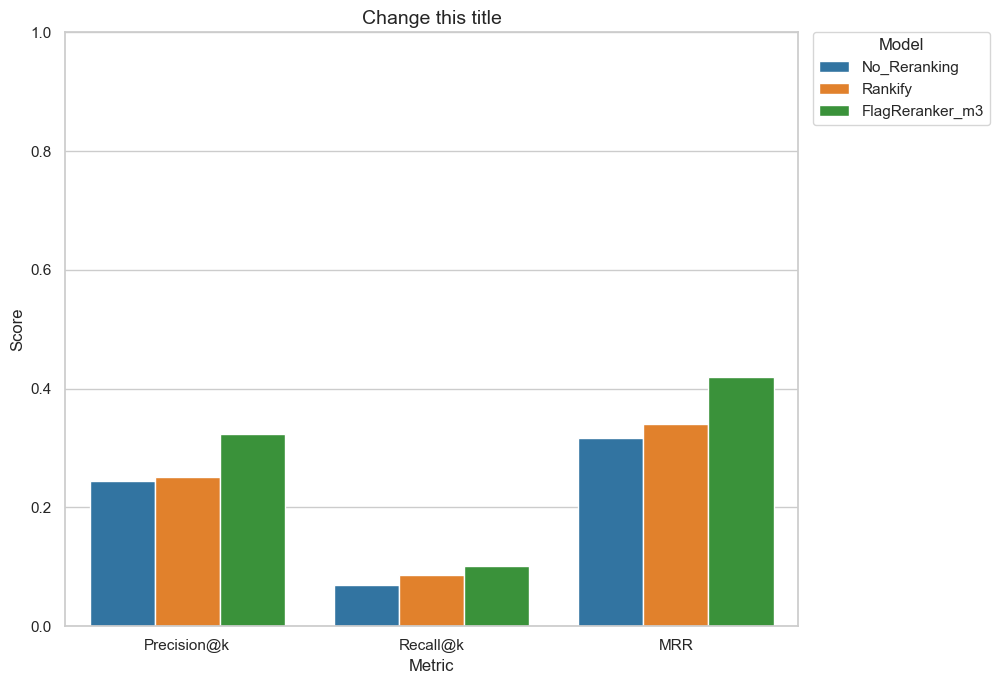

In [46]:
plot_evaluation_results_extended(final_set_evaluation_results, title="Change this title")

## 1.1 Setup of the environment

### Setting seeds and mounting Google Drive storage folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

In [ ]:
import pickle
import os
import re
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.7
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.5.19.0.38.36
astunparse                            1

In [ ]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [ ]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [ ]:
QQ = pd.DataFrame.from_dict(Q_A_ground_thruth_relevancy_dict, orient='index')
QQ.head()

,question,answer,possible_relevant_chunks,ground_truth_relevance,evaluation_comments
1,Who was president of ETH in 2003?,Olaf Kübler,"{3016_02, 2929_06, 2993_04, 3034_03, 4166_23, ...","{'3318_03': 0.0, '2550_02': 0.0, '3408_02': 0....",
2,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori","{3293_02, 2308_09, 3138_01, 2806_02, 3253_03, ...","{'3234_12': 0.0, '3318_03': 0.0, '0013_13': 0....",
3,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,"{3021_07, 1186_00, 0909_01, 3985_06, 3415_08, ...","{'2478_00': 0.0, '3788_00': 0.0, '3899_03': 0....",The criterion here: does it come up with a lis...
4,When did the InSight get to Mars?,26 November 2018,"{4180_00, 0932_00, 3838_07, 1087_02, 2855_01, ...","{'1098_04': 0.0, '0188_03': 0.0, '3592_05': 0....",
5,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,"{2343_00, 4193_04, 3986_11, 3395_06, 0180_02, ...","{'1376_09': 0.0, '2888_02': 0.0, '3999_05': 0....",


In [ ]:
print(QQ.columns)

Index(['question', 'answer', 'possible_relevant_chunks',
       'ground_truth_relevance', 'evaluation_comments'],
      dtype='object')


In [ ]:
df_chun = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [ ]:
df_chun.head()

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
0,0000_00,"Als 1950 die Meteorologen Jule Charney, Ragnar...",563,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,0
1,0000_01,## Erstaunliche Entwicklung der Klimamodelle\n...,804,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,1
2,0000_02,"«Alle Modelle sind falsch, aber einige sind nü...",881,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,2
3,0000_03,"Doch um die Gitterweite verkleinern zu können,...",536,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,3
4,0000_04,Bis ein hochaufgelöstes Modell auf einer neuen...,466,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,4


In [ ]:
print(df_chun.columns)

Index(['unique_chunk_id', 'chunk_text', 'chunk_length', 'total_chunks',
       'folder_path', 'file_name', 'year', 'month', 'language', 'type',
       'title', 'text_id', 'chunk_id'],
      dtype='object')


In [ ]:
type(QQ['possible_relevant_chunks'].head()[1])

set

In [ ]:
list(QQ['possible_relevant_chunks'][2])[0]

'3293_02'

In [ ]:
from nltk.tokenize import sent_tokenize

def get_chunk_sentences(chunk_ids, df_chunks):
    sentences = []
    for cid in chunk_ids:
        if cid in df_chunks.index:
            chunk_text = df_chunks.loc[cid]['chunk_text']
            sentences.extend(sent_tokenize(chunk_text))
    return sentences


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer("all-MiniLM-L6-v2")

def score_sentences(query, sentences):
    query_emb = model.encode(query, convert_to_tensor=True)
    sent_embs = model.encode(sentences, convert_to_tensor=True)
    scores = util.cos_sim(query_emb, sent_embs)[0].cpu().numpy()
    return scores


In [ ]:
def dslr_refine(query, chunk_ids, df_chunks, top_k=5):
    sentences = get_chunk_sentences(chunk_ids, df_chunks)
    if not sentences:
        return ""  # fallback for empty input
    scores = score_sentences(query, sentences)
    top_idx = scores.argsort()[-top_k:][::-1]
    top_sentences = [sentences[i] for i in top_idx]
    return " ".join(top_sentences)


In [ ]:
df_main["refined_context"] = df_main.apply(
    lambda row: dslr_refine(row["question"], row["possible_relevant_chunks"], df_chun),
    axis=1
)


there is a new column refined_context, where each row contains a query-focused, sentence-level refined passage assembled from the top relevant chunks.